# Propuesta Análisis Descriptivo Series de Tiempo

In [25]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math
from itertools import product

from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# from common.utils import load_data, mape

# plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## FUNCIONES

In [1]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

def optimize_SVR(parameters_list,data,variable_inte,criterio):
    """
        Return dataframe with parameters, corresponding MAPE and RMSE
        
        parameters_list - list with (timesteps,kernel, gamma,epsilon,C) tuples
        data - dataframe con la serie a modelar
        variable_inte = nombre de la columna que contiene la serie
        criterio = TOma el valor  de MAPE o RMSE
    """

    results = []
    
    for j in range(len(parameters_list)):
        try:
            
            scaler = MinMaxScaler()
            data[variable_inte] = scaler.fit_transform(pd.DataFrame(data[variable_inte].tolist()))
            train_data = data.values
            timesteps= parameters_list[j][0]
            train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
            
            x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
            
            model = SVR(kernel = parameters_list[j][1],
                        gamma = parameters_list[j][2], 
                        epsilon = parameters_list[j][3],
                        C = parameters_list[j][4])
            
            model.fit(x_train, y_train[:,0])
            
            
            y_train_pred = model.predict(x_train).reshape(-1,1)
            y_train_pred = scaler.inverse_transform(y_train_pred)
            y_train = scaler.inverse_transform(y_train)
            
            mape = mean_absolute_percentage_error(y_train, y_train_pred)
            MAE = mean_absolute_error(y_train,y_train_pred)
            MSE = mean_squared_error(y_train, y_train_pred) 
            RMSE = math.sqrt(MSE)
            
        except:
            continue
            
        MAPE = round(mape*100,4)
        RMSE = round(RMSE,5)
        MAE = round(RMSE,5)
        
        results.append([parameters_list[j][0],parameters_list[j][1],
                        parameters_list[j][2],parameters_list[j][3],
                        parameters_list[j][4],MAE,RMSE,mape])

    result_df = pd.DataFrame(results)
    result_df.columns = ['timesteps', 'kernel','gamma','epsilon','C','RMSE','MAE','MAPE']
    result_df = result_df[result_df[criterio]==min(result_df[criterio])]
    
    return result_df



https://duchesnay.github.io/pystatsml/statistics/time_series.html

**Lectura de la MDT**

In [4]:
df_final = pd.read_csv('MDT_data_tesis.csv', sep = '|')
df_final = df_final.drop(columns = 'Unnamed: 0')
df_final.head()

,nemotecnico,fecha,cantidad,volumen,precio_cierre,precio_mayor,precio_medio,precio_menor,variacion%,variacion_log
0,BCOLOMBIA,2019-10-02,284830.0,1.126933e+10,39500.0,39980.0,39565.11,39500.0,-1.25,-0.012579
1,BCOLOMBIA,2019-10-03,140793.0,5.645285e+09,40160.0,40200.0,40096.35,39060.0,1.67,0.016571
2,BCOLOMBIA,2019-10-04,24249.0,9.755599e+08,40300.0,40300.0,40230.93,39880.0,0.35,0.003480
3,BCOLOMBIA,2019-10-07,573422.0,2.294618e+10,40360.0,40400.0,40016.22,40000.0,0.15,0.001488
4,BCOLOMBIA,2019-10-08,97905.0,3.917192e+09,40200.0,40200.0,40010.14,39540.0,-0.40,-0.003972


## Variables globales

In [58]:
# steps = 330
variable_inte = 'variacion_log' # retorno logaritmicos lo que se llama retornos continuos
fecha_inicio_test = '2022-07-01'
path_grafico = 'C:/Users/lifes/Documents/5. MAESTRIA CIENCIA DE DATOS/TRABAJO DE GRADO/Notebook Tesis/Graficos tesis python/'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams["axes.edgecolor"] = "gray"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["figure.edgecolor"] = "gray"
# variable_inte = 'variacion%'

In [6]:
df_final['nemotecnico'] = df_final['nemotecnico'].str.strip()
acciones=list(df_final['nemotecnico'].unique())
# acciones.remove('MSCI')

### Separacion base train-test

# Metodo SVR

https://github.com/microsoft/ML-For-Beginners/blob/main/7-TimeSeries/3-SVR/README.md

**Optimización de Hiperparametros para el SVR**

In [2]:
timesteps =[5,10] #5,
kernel = ['rbf','sigmoid']
gamma = [0.5,1,1.5] #0,0.05,
epsilon = [0,0.01,0.05]
C = [25,50,100] #5,10,

parameters = product(timesteps,kernel, gamma,epsilon,C)
parameters_list = list(parameters)
print(len(parameters_list))

NameError: name 'product' is not defined

In [22]:
result_df_SVR = pd.DataFrame(columns=['Acción', 'timesteps', 'kernel','gamma',
                                      'epsilon','C','RMSE','MAE','MAPE'],
                             index=range(len(acciones)))

j=0
for i in acciones:
    
    df_interes = df_final[df_final['nemotecnico']==i]
    
    train = df_interes.copy()[(df_interes['fecha'] < fecha_inicio_test)]    
    train = train[[variable_inte]]

    result_SVR = optimize_SVR(parameters_list, train,variable_inte,'RMSE')

    result_df_SVR.iloc[j][0] = i
    result_df_SVR.iloc[j][1] = result_SVR.iloc[0,0]
    result_df_SVR.iloc[j][2] = result_SVR.iloc[0,1]
    result_df_SVR.iloc[j][3] = result_SVR.iloc[0,2]
    result_df_SVR.iloc[j][4] = result_SVR.iloc[0,3]    
    result_df_SVR.iloc[j][5] = result_SVR.iloc[0,4]
    result_df_SVR.iloc[j][6] = result_SVR.iloc[0,5]
    result_df_SVR.iloc[j][7] = result_SVR.iloc[0,6]

    j = j +1
    print(i)
    

result_df_SVR.to_csv(path_grafico+'parametro_SVR.csv', sep='|')

BCOLOMBIA
BOGOTA
BVC
CELSIA
CEMARGOS
CLH
CNEC
CORFICOLCF
ECOPETROL
EXITO
GRUPOARGOS
GRUPOAVAL
GRUPOSURA
ISA
NUTRESA
PFAVAL
PFCEMARGOS
PFCORFICOL
PFDAVVNDA
PFGRUPOARG
PFGRUPSURA


In [23]:
result_df_SVR

,Acción,timesteps,kernel,gamma,epsilon,C,RMSE,MAE,MAPE
0,BCOLOMBIA,5,rbf,0.5,0.0,25,0.02671,0.02671,NaN
1,BOGOTA,5,rbf,0.5,0.0,25,0.02271,0.02271,NaN
2,BVC,5,rbf,0.5,0.0,25,0.0176,0.0176,NaN
3,CELSIA,5,rbf,0.5,0.0,25,0.01622,0.01622,NaN
4,CEMARGOS,5,rbf,0.5,0.0,25,0.02516,0.02516,NaN
5,CLH,5,rbf,0.5,0.0,25,0.029,0.029,NaN
6,CNEC,5,rbf,0.5,0.0,25,0.01855,0.01855,NaN
7,CORFICOLCF,5,rbf,0.5,0.0,25,0.01627,0.01627,NaN
8,ECOPETROL,5,rbf,0.5,0.0,25,0.02552,0.02552,NaN
9,EXITO,5,rbf,0.5,0.0,25,0.02427,0.02427,NaN


### Estimacion con el modelo SVR optimizado - Test

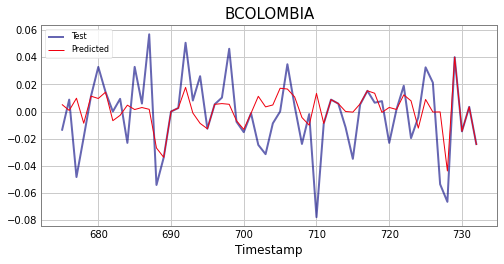

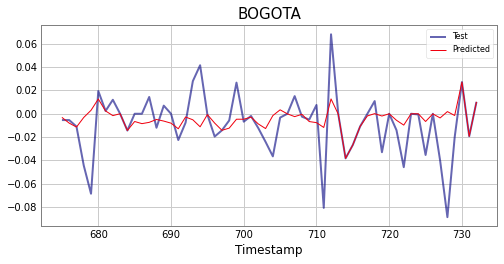

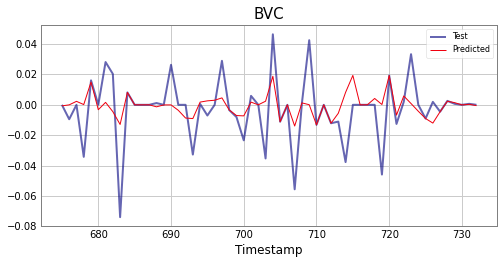

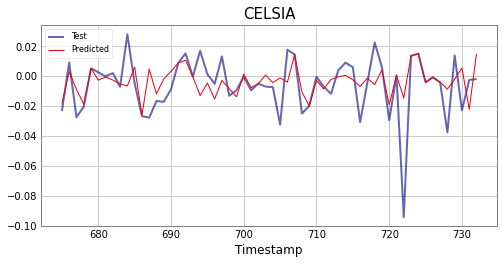

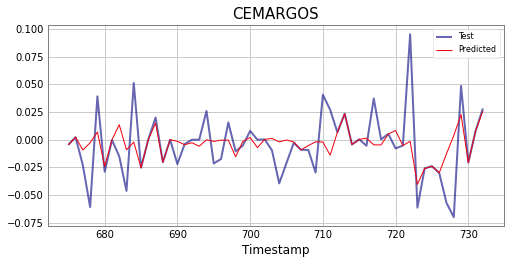

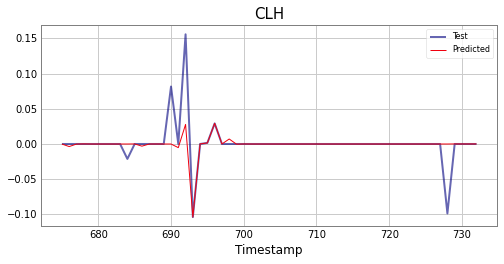

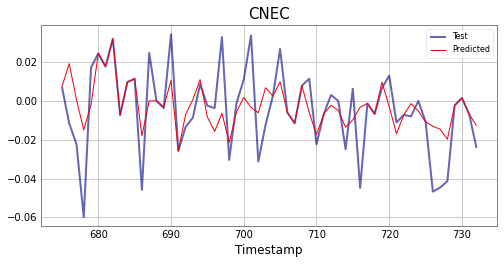

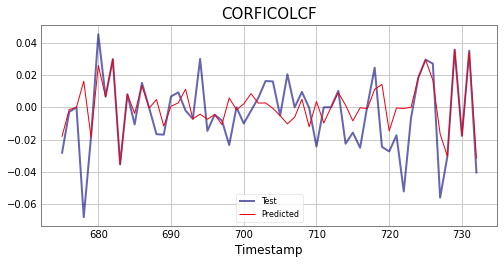

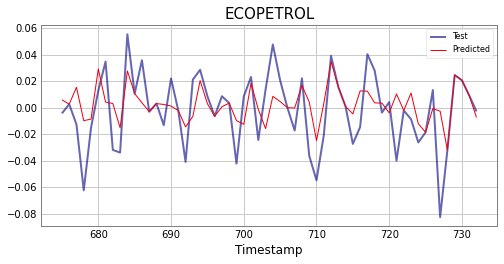

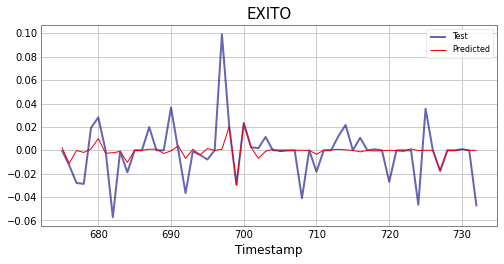

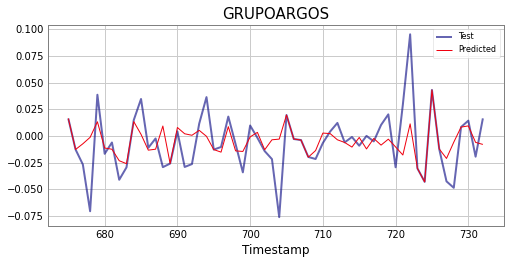

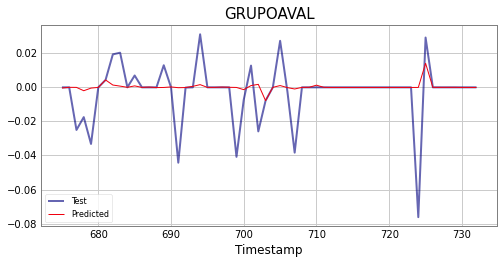

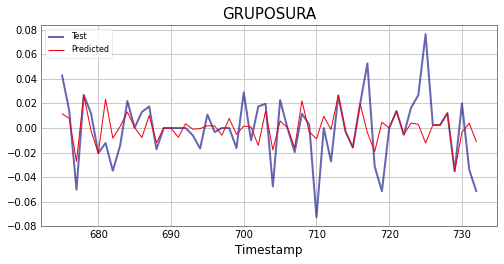

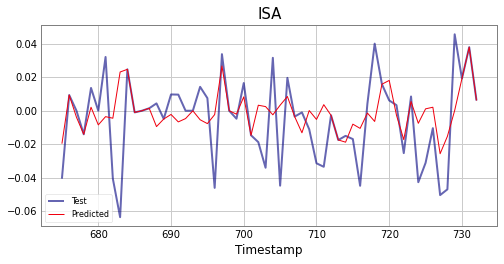

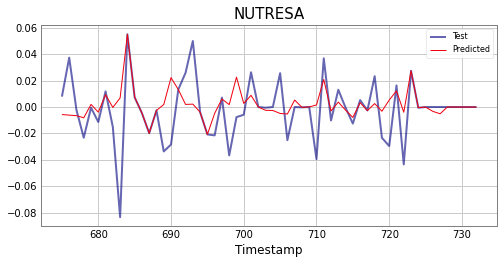

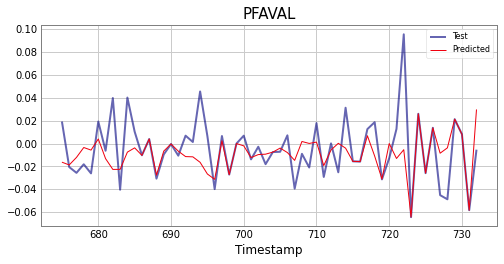

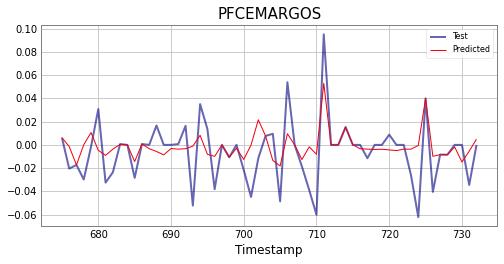

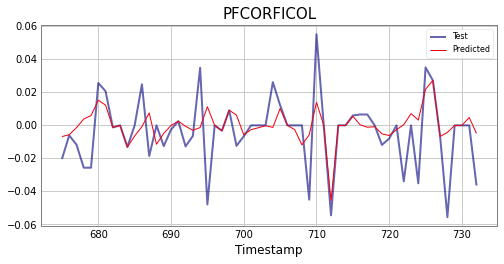

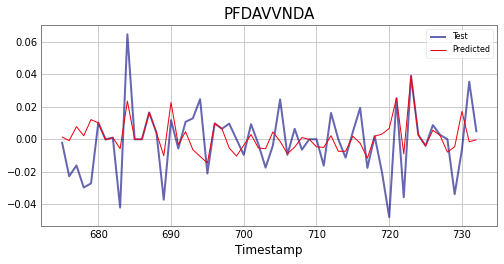

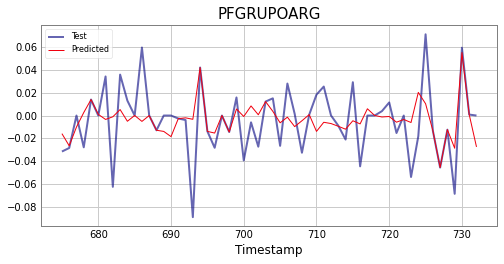

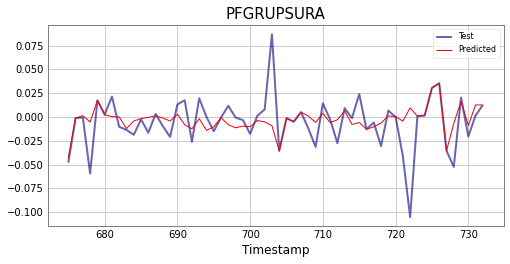

In [59]:
j=0
metricas_base_df = pd.DataFrame(columns=['Acción', 'RMSE','MAE','MAPE'],
                                index=range(len(acciones)))

for i in acciones:
    
    df_interes = df_final[df_final['nemotecnico']==i].reset_index()
    test = df_interes.copy()[(df_interes['fecha'] > fecha_inicio_test)] 
    test = test[[variable_inte]]  
    
    scaler = MinMaxScaler()
    test[variable_inte] = scaler.fit_transform(pd.DataFrame(test[variable_inte].tolist()))
    test_data = test.values
    parmetros_optimos = result_df_SVR[result_df_SVR['Acción']==i].reset_index(drop=True)
    
    timesteps = parmetros_optimos.iloc[0,1] 
    test_data_timesteps = np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
    
    x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]
    
    model = SVR(kernel = parmetros_optimos.iloc[0,2] ,
                gamma = parmetros_optimos.iloc[0,3], 
                C = parmetros_optimos.iloc[0,5],
                epsilon = parmetros_optimos.iloc[0,4])
    
    model.fit(x_test, y_test[:,0])
    
    y_test_pred = model.predict(x_test).reshape(-1,1)
    y_test_pred = scaler.inverse_transform(y_test_pred)
    y_test = scaler.inverse_transform(y_test)
    
    test_timestamps = df_interes[(df_interes['fecha'] > fecha_inicio_test)].index[timesteps-1:]
    
    test = df_interes.copy()[(df_interes['fecha'] > fecha_inicio_test)] 
    test = test[[variable_inte]][4:]
    
    mape = round(mean_absolute_percentage_error(test, y_test_pred)*100,4)
    MAE = round(mean_absolute_error(test,y_test_pred),5)
    MSE = mean_squared_error(test, y_test_pred) 
    RMSE = round(math.sqrt(MSE),5)

    metricas_base_df.iloc[j][0] = i
    metricas_base_df.iloc[j][1] = RMSE
    metricas_base_df.iloc[j][2] = MAE
    metricas_base_df.iloc[j][3] = RMSE
    j = j +1
       
    plt.figure(figsize=(7.28, 3.7 ))
    plt.plot(test.index, test, color = '#000080', linewidth=2, alpha = 0.6)
    plt.plot(test_timestamps, y_test_pred, color = '#F0000F', linewidth=1)
    plt.legend(['Test','Predicted'],loc=0, fontsize = 8)
    plt.xlabel('Timestamp')
    plt.title(i, fontsize = 15)
    plt.savefig('Graficos tesis python/prediccion_SVR/grafico_comparacion_prediccion_'+i+'.jpg',facecolor='white')
    plt.show()
    
    

In [61]:
metricas_base_df.to_csv(path_grafico+'metricas_model_SVR.csv', sep='|')
metricas_base_df

,Acción,RMSE,MAE,MAPE
0,BCOLOMBIA,0.02423,0.01566,0.02423
1,BOGOTA,0.02492,0.01444,0.02492
2,BVC,0.01874,0.01072,0.01874
3,CELSIA,0.01714,0.01041,0.01714
4,CEMARGOS,0.02566,0.01524,0.02566
5,CLH,0.02397,0.00606,0.02397
6,CNEC,0.0166,0.0108,0.0166
7,CORFICOLCF,0.01904,0.01134,0.01904
8,ECOPETROL,0.02317,0.01649,0.02317
9,EXITO,0.02155,0.0112,0.02155


In [ ]:
for i in acciones:
    
    df_interes = df_final[df_final['nemotecnico']==i]
    train = df_interes.copy()[(df_interes['fecha'] < fecha_inicio_test)]  
    train = train[[variable_inte]]  
    
    scaler = MinMaxScaler()
    train[variable_inte] = scaler.fit_transform(pd.DataFrame(train[variable_inte].tolist()))
    train_data = train.values
    parmetros_optimos = result_df_SVR[result_df_SVR['Acción']==i].reset_index(drop=True)
    
    timesteps = parmetros_optimos.iloc[0,1] 
    train_data_timesteps = np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
    
    x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
    
    model = SVR(kernel = parmetros_optimos.iloc[0,2] ,
                gamma = parmetros_optimos.iloc[0,3], 
                C = parmetros_optimos.iloc[0,5],
                epsilon = parmetros_optimos.iloc[0,4])
    
    model.fit(x_train, y_train[:,0])
    
    y_train_pred = model.predict(x_train).reshape(-1,1)
    y_train_pred = scaler.inverse_transform(y_train_pred)
    y_train = scaler.inverse_transform(y_train)
    
    train_timestamps = df_interes[:-steps].index[timesteps-1:]
    
    plt.figure(figsize=(25,6))
    plt.plot(df_interes.index, df_interes[variable_inte].astype('double'), color = '#000080', linewidth=2, alpha = 0.6)
    plt.plot(test_timestamps, y_test_pred, color = '#F0000F', linewidth=1)
    plt.legend(['Actual','Predicted'],loc=0, fontsize = 8)
    plt.xlabel('Timestamp')
    plt.title('Comparación Serie Real Vs Pred para la acción '+ i)
    plt.ylim(0.3,-0.3)  
    plt.show()
    
    
    

In [ ]:
plt.figure(figsize=(25,6))
plt.plot(train_timestamps, y_train, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps, y_train_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction")
plt.show()

In [ ]:

import math

error = mean_absolute_percentage_error(y_train, y_train_pred)
print('MAPE for training data: ', round(error*100,4), '%')

MSE = mean_squared_error(y_train, y_train_pred) 
RMSE = math.sqrt(MSE)
print('RMSE for training data: ', round(RMSE,6))



In [ ]:
result_df_arima = pd.DataFrame(columns=['Acción', 'p','d','q', 'P','D','Q','s','AIC'],index=range(len(acciones)))
j=0
for i in acciones:    
    
    df_interes = df_final[df_final['nemotecnico']==i]
    
    datos_train = df_interes[:-steps]
    
    train=datos_train[variable_inte]
    train = train.astype('double')

    result_arima = optimize_ARIMA(parameters_list, train)
    result_df_arima.iloc[j][0] = i
    result_df_arima.iloc[j][1] = result_arima.iloc[0,0]
    result_df_arima.iloc[j][2] = result_arima.iloc[0,1]
    result_df_arima.iloc[j][3] = result_arima.iloc[0,2]
    result_df_arima.iloc[j][4] = result_arima.iloc[0,3]    
    result_df_arima.iloc[j][5] = result_arima.iloc[0,4]
    result_df_arima.iloc[j][6] = result_arima.iloc[0,5]
    result_df_arima.iloc[j][7] = result_arima.iloc[0,6]
    result_df_arima.iloc[j][8] = result_arima.iloc[0,7]
    j = j +1
    print(i)

In [ ]:
result_df_arima

# Implementación Modelo Garch sobre los errores

### Tuneando Hiperparametros para modelo GARCH

https://arch.readthedocs.io/en/latest/univariate/generated/arch.univariate.GARCH.html#arch.univariate.GARCH

In [ ]:
p = range(0, 3, 1)
q = range(0, 3, 1)

parameters = product(p, q)
parameters_list = list(parameters)
print(len(parameters_list))

In [ ]:
result_df_garch = pd.DataFrame(columns=['Acción', 'p','q', 'AIC'],index=range(len(df_list)))

for i in range(len(df_list1)):
    
    datos_train = df_list1[i][:-steps]
    datos_test  = df_list1[i][-steps:]
    
    train=datos_train[variable_inte]
    train = train.astype('double')
    test=datos_test[variable_inte]
    test = test.astype('double')
    
    model_arima = ARIMA(train, order=(result_df_arima.iloc[i][1],result_df_arima.iloc[i][2],result_df_arima.iloc[i][3])).fit()
    arima_residuals = model_arima.resid

    result_garch = optimize_GARCH(parameters_list, arima_residuals)
    result_df_garch.iloc[i][0] = str(df_name[i])[9:]
    result_df_garch.iloc[i][1] = result_garch.iloc[0,0]
    result_df_garch.iloc[i][2] = result_garch.iloc[0,1]
    result_df_garch.iloc[i][3] = result_garch.iloc[0,2]
    
result_df_garch

### Pronostico modelo ARIMA GARCH

https://medium.com/analytics-vidhya/arima-garch-forecasting-with-python-7a3f797de3ff

In [ ]:
i=0
# fit ARIMA on returns 

datos_train = df_list1[i][:-steps]
datos_test  = df_list1[i][-steps:] 

train=datos_train[variable_inte]
train = train.astype('double')
test=datos_test[variable_inte]
test = test.astype('double')
model_arima = ARIMA(train, order=(result_df_arima.iloc[i][1],result_df_arima.iloc[i][2],result_df_arima.iloc[i][3])).fit()
arima_residuals = model_arima.resid
model_arch = arch_model(arima_residuals, mean='Zero', vol='GARCH', p=int(result_df_garch.iloc[i][1]),q=int(result_df_garch.iloc[i][2])).fit()
        

# Use ARIMA to predict mu
predicted_mean = model_arima.forecast(steps)
# Use GARCH to predict the residual
garch_forecast = model_arch.forecast(horizon=steps)
predicted_varianza = garch_forecast.variance.values[-1, :]
# predicted_varianza = garch_forecast.mean#.iloc[-1]
# Combine both models' output: yt = mu + et
prediction = predicted_mean + predicted_varianza

In [ ]:
predicted_mean

In [ ]:
model_arima.forecast(steps)

In [ ]:
steps

In [ ]:
predicted_mean+predicted_varianza

In [ ]:
len(garch_forecast.variance.values[-1, :])

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
train.plot(ax=ax, label='train')
test.plot(ax=ax, label='test')
prediction.plot(ax=ax, label='predicciones',linewidth=2.0)
ax.legend();

In [ ]:
result_df_garch['q'][i]

In [ ]:
datos_train[variable_inte].astype('double')

In [ ]:
datos_train = df_list1[i][:-steps]
datos_test  = df_list1[i][-steps:].reset_index(drop=True)
model_fit = arch_model(datos_train[variable_inte].astype('double'), mean='Zero', vol='GARCH', p=int(result_df_garch['p'][i]),q=int(result_df_garch['q'][i])).fit()
model_fit.summary()

In [ ]:
pip install pmdarima

In [ ]:
import pmdarima
import arch

In [ ]:
result_df_garch

# Aqui vamos

# ---------------------------------------------------------------------------------------------------------------

### Sarima

In [ ]:
parameters_list

In [ ]:
train

In [ ]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 7, train)
result_df